In [41]:
import pandas as pd # type: ignore
from datetime import datetime # type: ignore
import numpy as np #type: ignore
from sklearn.metrics import mean_squared_error # type: ignore

In [42]:
import glob

folder_path = 'LJP'

# Get a list of all CSV files in the folder
csv_files = glob.glob(folder_path + '/*.csv')

# Create an empty list to store the DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
	df = pd.read_csv(file)
	dfs.append(df)

# Concatenate all the DataFrames together
df_arso = pd.concat(dfs, ignore_index=True)
df_arso.head()

,station id,station name,valid,T [°C],količina padavin [mm],globalno sev. [W/m2]
0,_3047,Letališče Jožeta Pučnika Ljubljana,2022-01-01 00:00,-2.6,0.0,0.0
1,_3047,Letališče Jožeta Pučnika Ljubljana,2022-01-01 00:10,-2.6,NaN,NaN
2,_3047,Letališče Jožeta Pučnika Ljubljana,2022-01-01 00:20,-2.6,NaN,NaN
3,_3047,Letališče Jožeta Pučnika Ljubljana,2022-01-01 00:30,-3.4,0.0,0.0
4,_3047,Letališče Jožeta Pučnika Ljubljana,2022-01-01 00:40,-2.9,NaN,NaN


In [43]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df_arso):
	# Filter rows based on column: ' valid'
	df_arso = df_arso[df_arso[' valid'].str.endswith("00", na=False)]
	# Drop columns: 'station id', ' station name'
	df_arso = df_arso.drop(columns=['station id', ' station name'])
	# Change column type to datetime64[ns] for column: ' valid'
	df_arso = df_arso.astype({' valid': 'datetime64[ns]'})
	# Rename column ' valid' to 'datum'
	df_arso = df_arso.rename(columns={' valid': 'datum'})
	return df_arso

df_arso_clean = clean_data(df_arso.copy())
df_arso_clean.head()

,datum,T [°C],količina padavin [mm],globalno sev. [W/m2]
0,2022-01-01 00:00:00,-2.6,0.0,0.0
6,2022-01-01 01:00:00,-3.2,0.0,0.0
12,2022-01-01 02:00:00,-3.9,0.0,0.0
18,2022-01-01 03:00:00,-2.8,0.0,0.0
24,2022-01-01 04:00:00,-3.1,0.0,0.0


In [44]:
df_eles = pd.read_csv('ELES.csv', sep=';')

"""
Cell generated by Data Wrangler.
"""
from datetime import datetime

def clean_data(df_eles):
    df_eles['datum'] = pd.to_datetime(df_eles['datum'], dayfirst=True)
    df_eles['ura'] = df_eles['ura'].str[1:3].astype(int) - 1
    df_eles['datum'] = df_eles['datum'] + pd.to_timedelta(df_eles['ura'], unit='h')
    df_eles.drop(columns=['ura', 'predvidena_proizvodnja', 'dejanska_proizvodnja', 'nek', 'termo', 'hidro', 'predviden_prevzem'], inplace=True)
    # Filter rows based on column: 'datum'
    # df_eles = df_eles[df_eles['datum'] >= datetime.strptime('2024-08-01T00:00:00.000Z', '%Y-%m-%dT%H:%M:%S.%fZ')]
    return df_eles

df_eles_clean = clean_data(df_eles.copy())
df_eles_clean.head()

,datum,dejanski_prevzem
0,2022-01-01 00:00:00,1044.0
1,2022-01-01 01:00:00,1018.0
2,2022-01-01 02:00:00,975.0
3,2022-01-01 03:00:00,944.0
4,2022-01-01 04:00:00,936.0


In [45]:
df_pokritost = pd.read_csv('LJP_pokritost_2022-2024.csv')
df_pokritost['datum'] = pd.to_datetime(df_pokritost[' valid'])
df_pokritost = df_pokritost.drop(columns=['station id', ' station name', ' valid'])
df_pokritost.head()

,oblačnost [%],datum
0,37.0,2022-01-01
1,40.0,2022-01-02
2,80.0,2022-01-03
3,100.0,2022-01-04
4,100.0,2022-01-05


In [46]:
df_prazniki = pd.read_csv('prazniki.csv', header=None)
df_prazniki['datum'] = pd.to_datetime(df_prazniki[0])
df_prazniki = df_prazniki.drop(columns=[0])
df_prazniki = df_prazniki.rename(columns={1: 'holiday'})

# Generate a new DataFrame with all dates between 2022-01-01 and 2024-10-23
df_all_dates = pd.DataFrame({'datum': pd.date_range('2022-01-01', '2024-10-23')})

# Merge the new DataFrame with df_prazniki, filling in missing values with 0
df_prazniki = pd.merge(df_all_dates, df_prazniki, on='datum', how='left').fillna(0)

df_prazniki.head()

,datum,holiday
0,2022-01-01,1.0
1,2022-01-02,1.0
2,2022-01-03,0.0
3,2022-01-04,0.0
4,2022-01-05,0.0


In [47]:
df1 = pd.merge(df_eles_clean, df_arso_clean, on='datum')
df2 = pd.merge(df1, df_pokritost, on='datum', how='outer')
df = pd.merge(df2, df_prazniki, on='datum', how='outer')
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    # Drop duplicate rows in column: 'datum'
    df = df.drop_duplicates(subset=['datum'])
    # Renames
    df = df.rename(columns={'datum': 'date', 
                            'dejanski_prevzem': 'consumption',
                            'T [°C]': 'temperature',
                            'količina padavin [mm]': 'precipitation',
                            'globalno sev. [W/m2]': 'irradiation',
                            'oblačnost [%]': 'cloudiness'
                        })
    df.ffill(inplace=True)
    df = df[(df['date'].dt.day != 29) | (df['date'].dt.month != 2)]
    df = df.drop(df.index[0])
    return df

df = clean_data(df.copy())
df.head()

,date,consumption,temperature,precipitation,irradiation,cloudiness,holiday
1,2022-01-01 01:00:00,1018.0,-3.2,0.0,0.0,37.0,1.0
2,2022-01-01 02:00:00,975.0,-3.9,0.0,0.0,37.0,1.0
3,2022-01-01 03:00:00,944.0,-2.8,0.0,0.0,37.0,1.0
4,2022-01-01 04:00:00,936.0,-3.1,0.0,0.0,37.0,1.0
5,2022-01-01 05:00:00,952.0,-4.1,0.0,0.0,37.0,1.0


# Moja koda od tu naprej

Dodamo vse ostale stvari v model za train

In [48]:
from sklearn.ensemble import GradientBoostingRegressor # type: ignore

df_hourly = df.copy()
df_hourly['shifted_consumption_168'] = df_hourly['consumption'].shift(168)
df_hourly['shifted_consumption_48'] = df_hourly['consumption'].shift(48)
df_hourly['shifted_consumption_8760'] = df_hourly['consumption'].shift(8760)
df_hourly['hour'] = df_hourly['date'].dt.hour
df_hourly['weekDay'] = df_hourly['date'].dt.weekday

# Split the dataset based on the cutoff date
cutoff_date = '2024-09-01 00:00:00'
train_data = df_hourly[df_hourly['date'] < cutoff_date].dropna(how='any')
test_data = df_hourly[df_hourly['date'] >= cutoff_date]

C:\Users\patri\AppData\Local\Temp\ipykernel_8432\4116720110.py:26: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


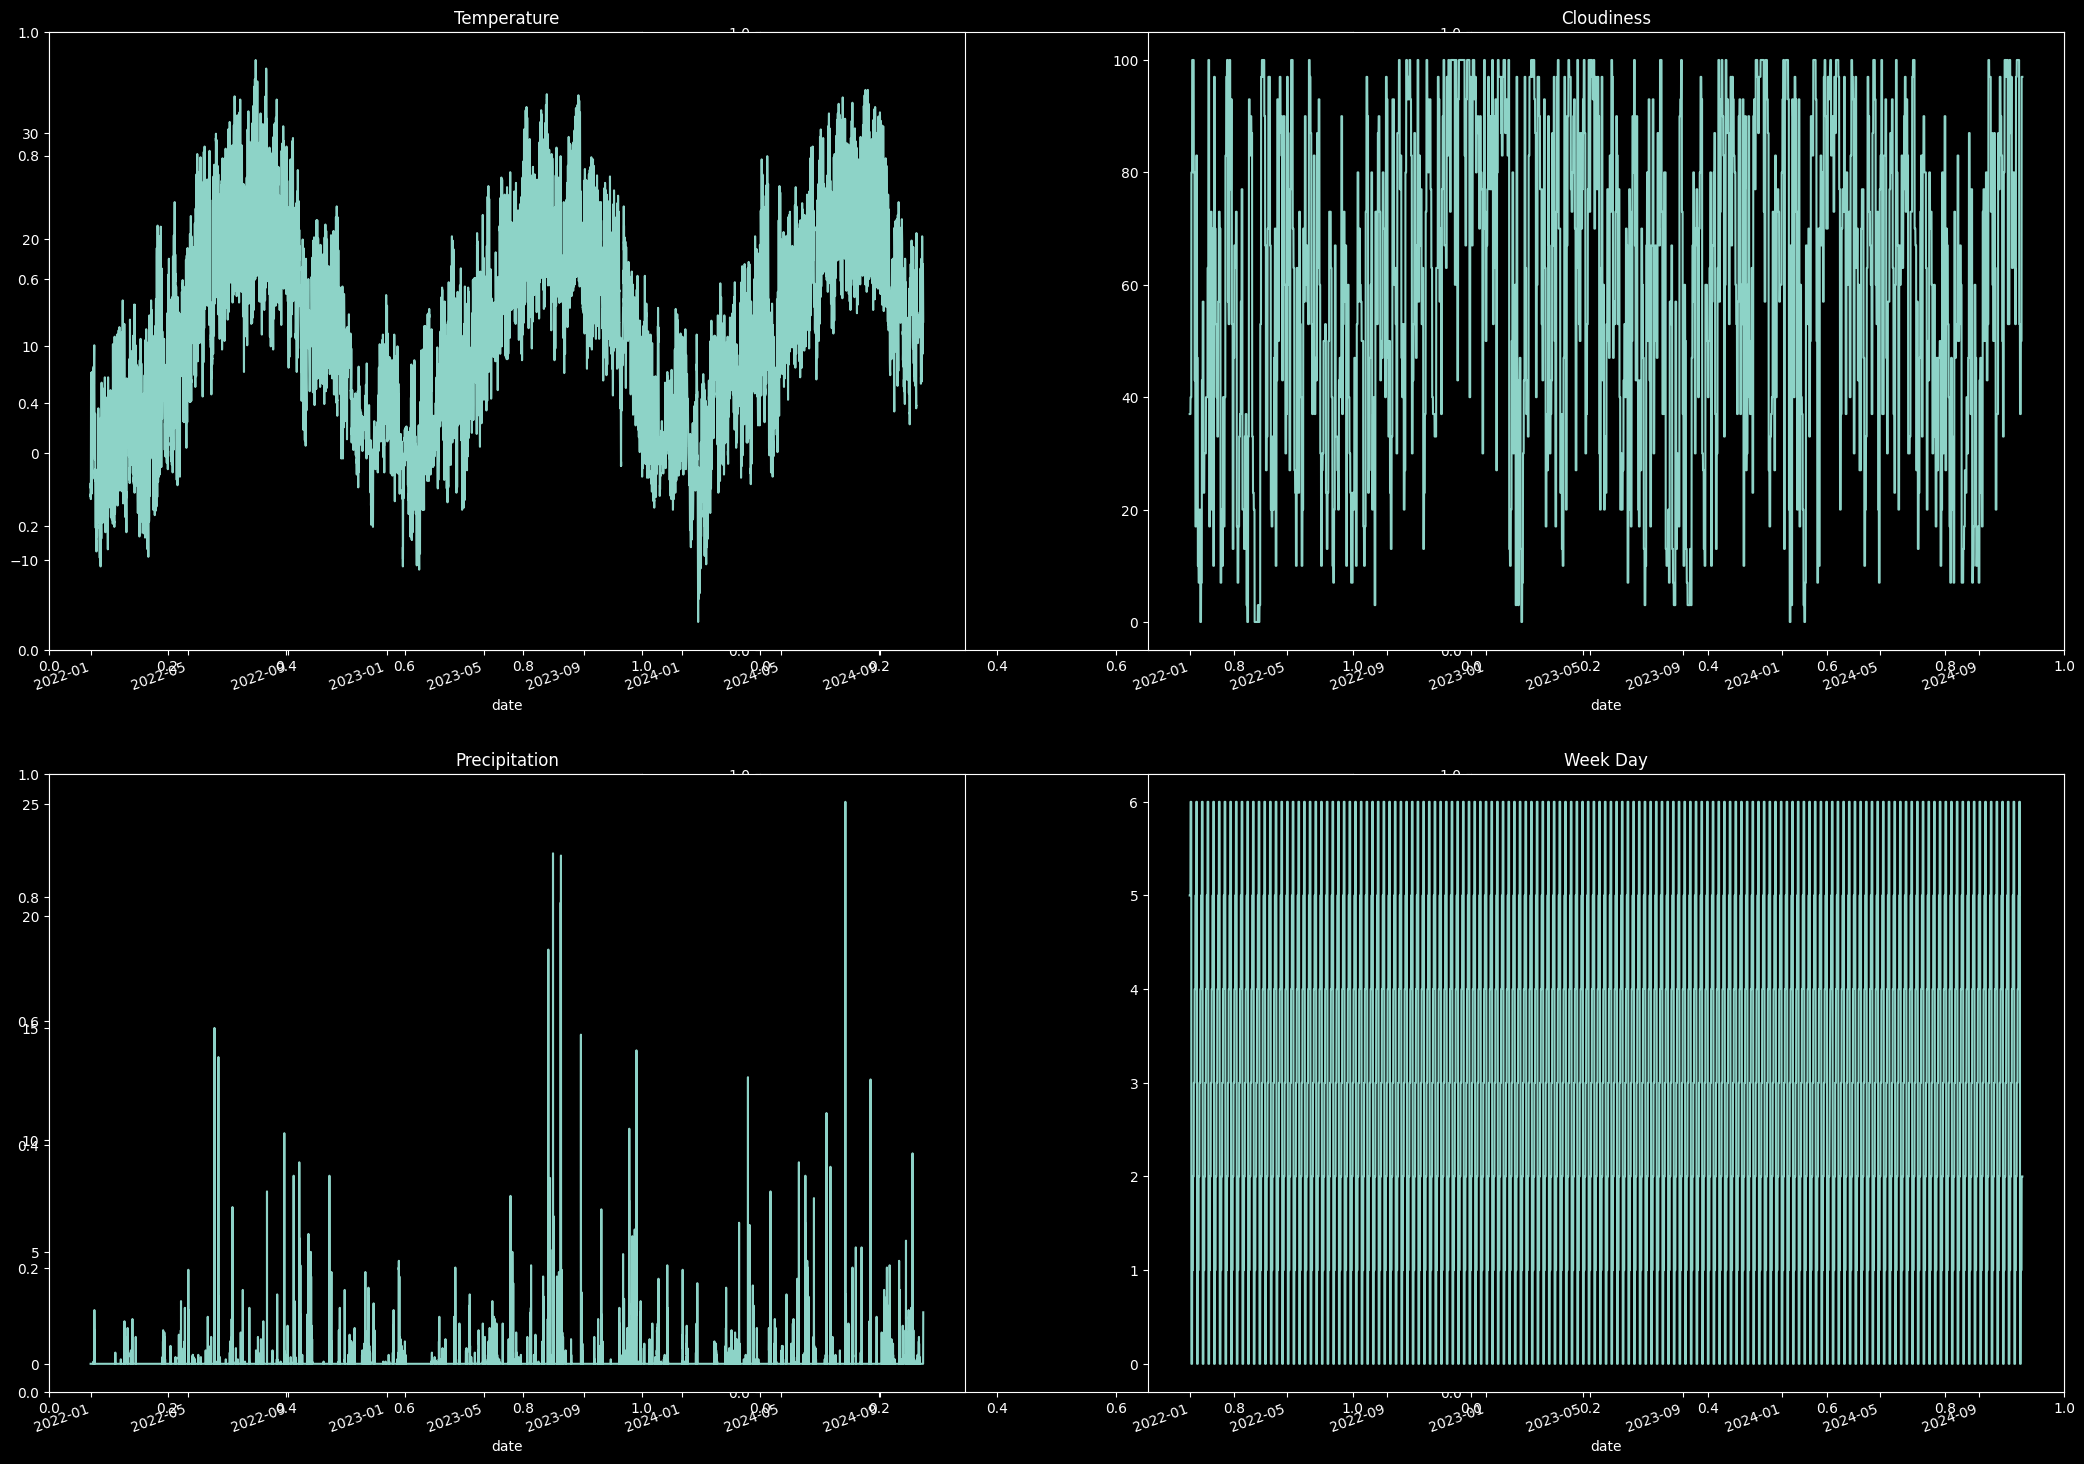

In [135]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.subplots(nrows=2, ncols=3, figsize=(26, 20))

ax = plt.subplot(2, 2, 1)
df_hourly['temperature'].head()
df_hourly['temperature'].plot(rot=20)
plt.title('Temperature')

ax = plt.subplot(2, 2, 2)
df_hourly['cloudiness'].head()
df_hourly['cloudiness'].plot(rot=20)
plt.title('Cloudiness')

ax = plt.subplot(2, 2, 3)
df_hourly['precipitation'].head()
df_hourly['precipitation'].plot(rot=20)
plt.title('Precipitation')

ax = plt.subplot(2, 2, 4)
df_hourly['weekDay'].head()
df_hourly['weekDay'].plot(rot=20)
plt.title('Week Day')

plt.tight_layout()
plt.show()

# LSTM

In [49]:
import tensorflow as tf # type: ignore
from tensorflow.keras.datasets import imdb # type: ignore
from tensorflow.keras.layers import Embedding, Dense, LSTM # type: ignore
from tensorflow.keras.losses import BinaryCrossentropy # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore

In [56]:
df_hourly.describe()

,consumption,temperature,precipitation,irradiation,cloudiness,holiday,shifted_consumption_168,shifted_consumption_48,shifted_consumption_8760,hour,weekDay
count,24620.000000,24620.000000,24620.000000,24620.000000,24620.000000,24620.000000,24452.000000,24572.000000,15860.000000,24620.000000,24620.000000
mean,1295.162266,11.396917,0.082673,153.505280,60.272502,0.034078,1295.358621,1295.144189,1324.220050,11.501625,2.998578
std,300.468137,9.060805,0.606255,241.815518,29.538328,0.181433,300.761356,300.616497,293.738964,6.921707,2.002567
min,0.000000,-15.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,411.000000,0.000000,0.000000
25%,1080.000000,4.300000,0.000000,0.000000,37.000000,0.000000,1080.000000,1080.000000,1108.000000,6.000000,1.000000
50%,1281.000000,11.500000,0.000000,7.000000,63.000000,0.000000,1281.000000,1281.000000,1311.500000,12.000000,3.000000
75%,1509.000000,17.900000,0.000000,228.000000,87.000000,0.000000,1509.000000,1509.000000,1534.000000,18.000000,5.000000
max,2171.000000,36.800000,25.100000,1090.000000,100.000000,1.000000,2171.000000,2171.000000,2146.000000,23.000000,6.000000


In [51]:
df_hourly.index = df_hourly['date']
df_hourly.drop('date', axis=1, inplace=True)
df_hourly.head()

,consumption,temperature,precipitation,irradiation,cloudiness,holiday,shifted_consumption_168,shifted_consumption_48,shifted_consumption_8760,hour,weekDay
date,,,,,,,,,,,
2022-01-01 01:00:00,1018.0,-3.2,0.0,0.0,37.0,1.0,NaN,NaN,NaN,1,5
2022-01-01 02:00:00,975.0,-3.9,0.0,0.0,37.0,1.0,NaN,NaN,NaN,2,5
2022-01-01 03:00:00,944.0,-2.8,0.0,0.0,37.0,1.0,NaN,NaN,NaN,3,5
2022-01-01 04:00:00,936.0,-3.1,0.0,0.0,37.0,1.0,NaN,NaN,NaN,4,5
2022-01-01 05:00:00,952.0,-4.1,0.0,0.0,37.0,1.0,NaN,NaN,NaN,5,5


In [52]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

In [113]:
df_norm = normalize(df_hourly.values)
df_norm = pd.DataFrame(df_norm)
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.922454,-1.611028,-0.136369,-0.634816,-0.787891,5.323951,NaN,NaN,NaN,-1.517232,0.999448
1,-1.065566,-1.688286,-0.136369,-0.634816,-0.787891,5.323951,NaN,NaN,NaN,-1.372756,0.999448
2,-1.168741,-1.566881,-0.136369,-0.634816,-0.787891,5.323951,NaN,NaN,NaN,-1.228280,0.999448
3,-1.195367,-1.599992,-0.136369,-0.634816,-0.787891,5.323951,NaN,NaN,NaN,-1.083804,0.999448
4,-1.142115,-1.710359,-0.136369,-0.634816,-0.787891,5.323951,NaN,NaN,NaN,-0.939329,0.999448


In [114]:
# 52 dni / 1026 dni - 29/02
# training_size = int (((1025- 52)/1025) * df_norm.shape[0])

training_size = int (0.8 * df_norm.shape[0])
train_data = df_norm.loc[0 : training_size - 1]
val_data = df_norm.loc[training_size:]

print(training_size, train_data.shape, val_data.shape)

19696 (19696, 11) (4924, 11)


In [118]:
# 24620 vals
# odstejemo zadnje 3 dni

x_train = train_data.values
y_train = df_norm.iloc[19696:].values

sequence_length = int(24 * 7)

In [119]:
from tensorflow import keras

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train,
    sequence_length=sequence_length,
    sampling_rate=6,
    batch_size=64,
)

In [120]:
x_val = val_data.iloc[-168:].values
y_val = df_norm.iloc[-168:].values

print(x_val.shape, y_val.shape)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=6,
    batch_size=64,
)

(168, 11) (168, 11)


In [121]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(name="Weather_forcaster",inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "Weather_forcaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 168, 11)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,665 (22.13 KB)

 Trainable params: 5,665 (22.13 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
history = model.fit(
    dataset_train,
    epochs=15,
    validation_data=dataset_val
)

Epoch 1/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: nan
Epoch 2/15
 2/77 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: nan

C:\Users\patri\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: nan
Epoch 3/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: nan
Epoch 4/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: nan
Epoch 5/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: nan
Epoch 6/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: nan
Epoch 7/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: nan
Epoch 8/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: nan
Epoch 9/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: nan
Epoch 10/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: nan
Epoch 11/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: nan
Epoch 12/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: nan
Epoch 13/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: nan
Epoch 14/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: nan
Epoch 15/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: nan


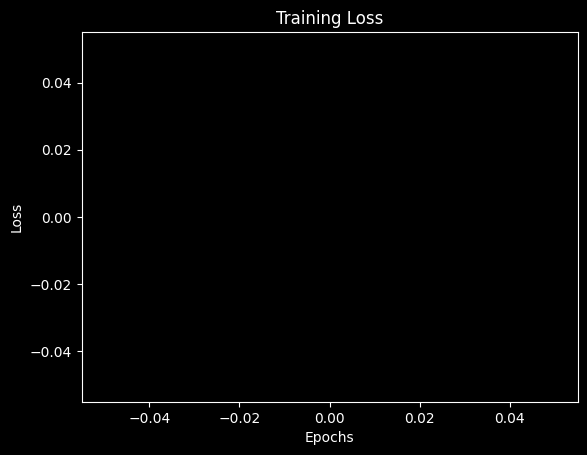

In [126]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

loss = history.history["loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [130]:
temp_mean = df_hourly['consumption'].mean(axis=0)
temp_std = df_hourly['consumption'].std(axis=0)

for x, y in dataset_val.skip(12):
    history_data = x[0][:, 1].numpy() * temp_std + temp_mean
    true_value = y[0].numpy() * temp_std + temp_mean
    prediction = model.predict(x)[0] * temp_std + temp_mean
    time_steps = list(range(-(history_data.shape[0]), 0))
    plt.plot(time_steps, history_data)
    plt.plot(36, true_value, "gD")
    plt.plot(36, prediction, "rX")
    plt.legend(["History", "True Future", "Model Prediction"])
    plt.xlabel("Time")
    plt.show()